<!--
SPDX-FileCopyrightText: 2022 The eminus developers
SPDX-License-Identifier: Apache-2.0
-->
# Domain generation

In [ ]:
# mypy: disable-error-code="index"
import time

from eminus import Atoms, read, SCF
from eminus.dft import get_n_single
from eminus.domains import domain_cuboid, domain_isovalue, domain_sphere, truncate
from eminus.energies import get_Esic
from eminus.extras import view_atoms
from eminus.orbitals import KSO

In [2]:
# Start by creating an `Atoms` object for lithium hydride
# Use a small `s` to make the resulting grid not too dense to display it
atoms = Atoms(*read("LiH.xyz"), ecut=5, center=True)
scf = SCF(atoms)
scf.run();

XYZ file comment: "Experimental geometry from CCCBDB: https://cccbdb.nist.gov/exp2x.asp?casno=7580678&charge=0"
Start auto minimization...
Method  Iteration  Etot [Eh]    dEtot [Eh]   |Gradient|   
pccg           1   +2.082730    
pccg           2   -1.017932    -3.1007e+00  [+4.35e+02]  
pccg           3   -3.964239    -2.9463e+00  [+6.65e+01]  
pccg           4   -4.611312    -6.4707e-01  [+5.56e-01]  
pccg           5   -5.430747    -8.1943e-01  [+2.53e-01]  
pccg           6   -5.550987    -1.2024e-01  [+2.18e-02]  
pccg           7   -5.582962    -3.1975e-02  [+3.56e-03]  
pccg           8   -5.592126    -9.1643e-03  [+1.18e-03]  
pccg           9   -5.595196    -3.0691e-03  [+3.26e-04]  
pccg          10   -5.596356    -1.1605e-03  [+1.29e-04]  
pccg          11   -5.596940    -5.8368e-04  [+5.65e-05]  
pccg          12   -5.597159    -2.1956e-04  [+2.69e-05]  
pccg          13   -5.597217    -5.7362e-05  [+6.79e-06]  
pccg          14   -5.597234    -1.7485e-05  [+2.19e-06]  
pc

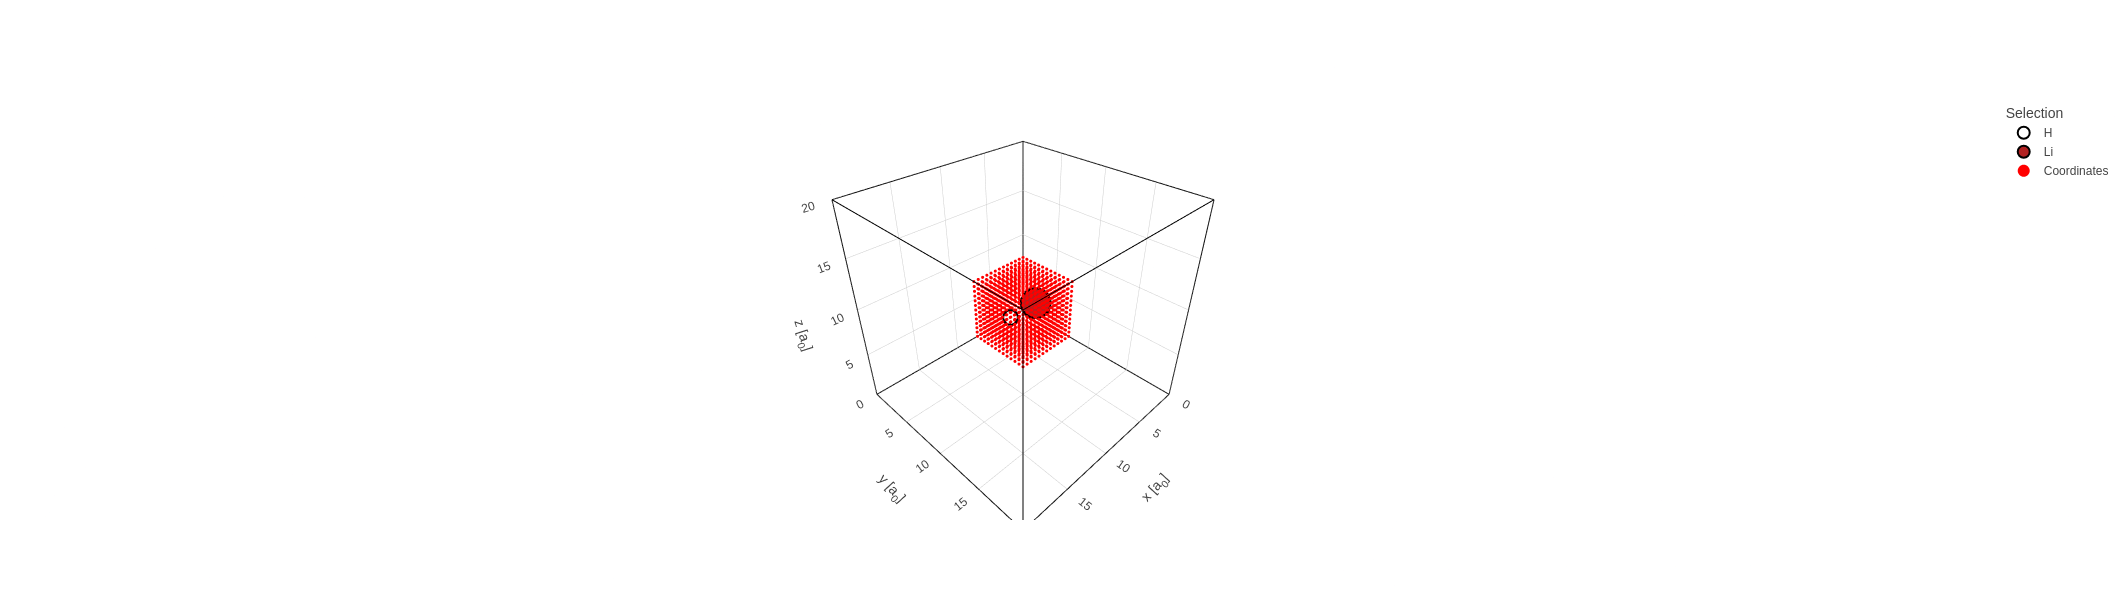

In [3]:
# Create a boolean mask for a cuboidal domain
# This will create a domain with side lengths of 3 Bohr,
# with the center in the center at the center of mass of our molecule
mask = domain_cuboid(atoms, 3)

# Display the domain along with the atom positions
# The `view_atoms` function can be used outside of notebooks
view_atoms(atoms, atoms.r[mask])

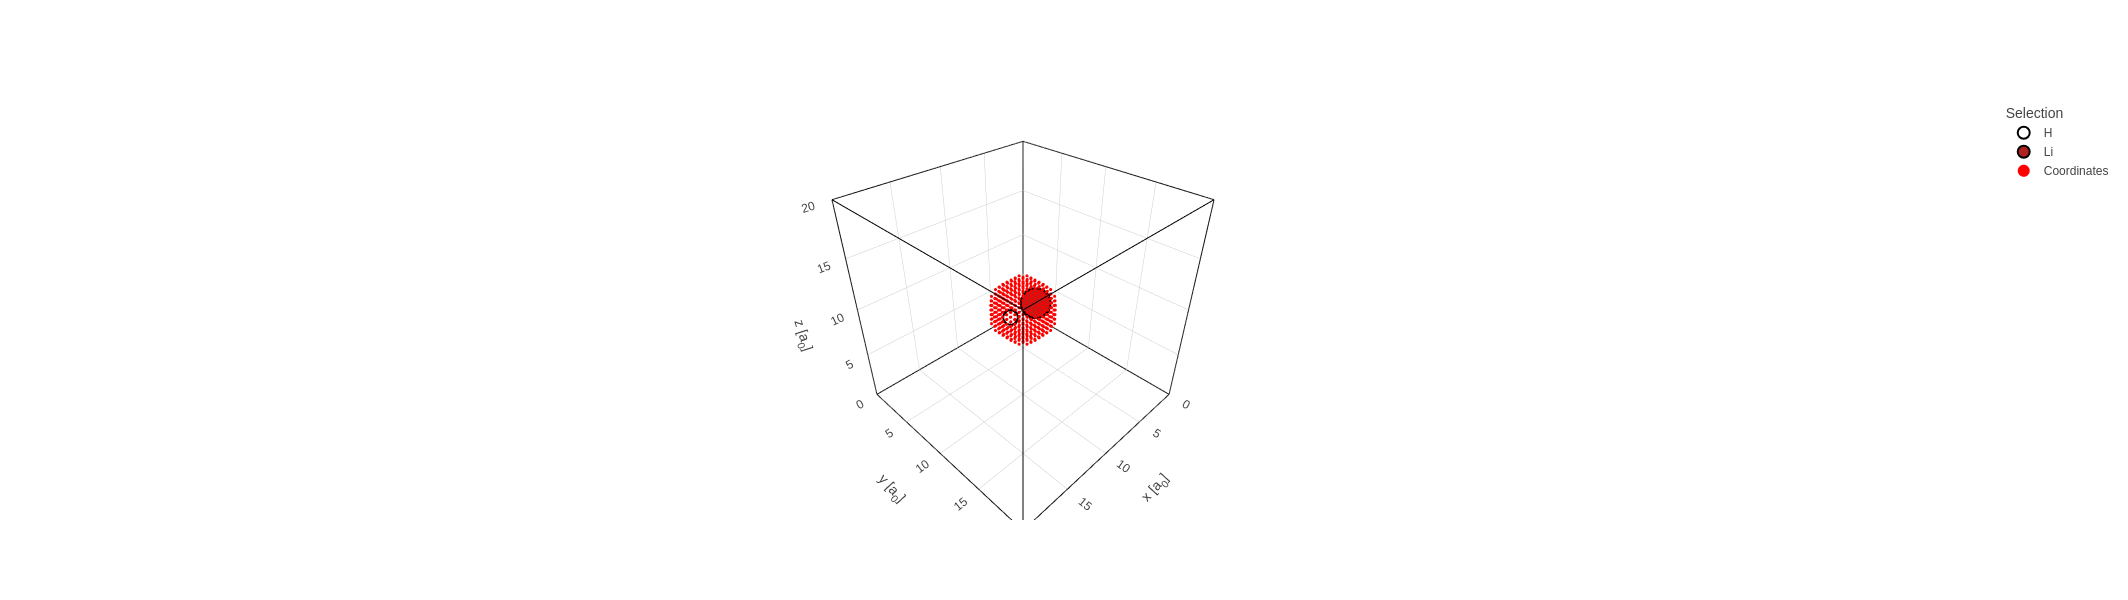

In [4]:
# The same can be done for a spherical domain with a radius of 3 Bohr
mask = domain_sphere(atoms, 3)
view_atoms(atoms, atoms.r[mask])

In [5]:
# One can also define more than one center
# This will create multiple domains and merge them, here shown with the atom positions as centers
mask = domain_sphere(atoms, 3, atoms.pos)
view_atoms(atoms, atoms.r[mask])

In [6]:
# An isovalue can be used to generate a domain from a real-space field data like the density
mask = domain_isovalue(scf.n, 1e-3)
view_atoms(atoms, atoms.r[mask])

# The same can be done for orbitals
# psi = KSO(scf)
# mask = domain_isovalue(psi[0][0, :, 0], 1e-2)
# view_atoms(atoms, atoms.r[mask])

In [7]:
# Compare to the density volume plot
view_atoms(scf, plot_n=True, percent=95)

In [8]:
# Truncated densities can be used to calculate, e.g., SIC energies
# Calculate the single-electron densities from Kohn-Sham orbitals first
psi = KSO(scf)
ni = get_n_single(atoms, atoms.J(psi))

In [9]:
# Calculate the SIC energy for untruncated densities
start = time.perf_counter()
esic = get_Esic(scf, scf.W, ni)
end = time.perf_counter()
print(f"Esic(untruncated) = {esic:.9f} Eh\nTime(untruncated) =  {end - start:.6f} s")

# Calculate the SIC energy for truncated densities
# One can notice a small energy deviation, but a faster calculation time
mask = domain_isovalue(ni, 1e-4)
ni_trunc = truncate(ni, mask)
start = time.perf_counter()
esic_trunc = get_Esic(scf, scf.W, ni_trunc)
end = time.perf_counter()
print(f"Esic( truncated ) = {esic_trunc:.9f} Eh\nTime( truncated ) =  {end - start:.6f} s")

Esic(untruncated) = -0.175824478 Eh
Time(untruncated) =  0.040452 s
Esic( truncated ) = -0.176096991 Eh
Time( truncated ) =  0.013908 s


In [10]:
# The truncated SIC energy will converge for smaller isovalues to the untruncated value
mask = domain_isovalue(ni, 0)
ni_trunc = truncate(ni, mask)
esic_trunc = get_Esic(scf, scf.W, ni_trunc)
print(esic == esic_trunc)

tensor(True)
